In [11]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *

### Read data from database
###### 

In [ ]:
df = database_query("SELECT * FROM SensorData")
df
alussa = len(df)

### Find and delete outliers
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Datan%20Siivous/Z-score%20Outlierit.md


Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


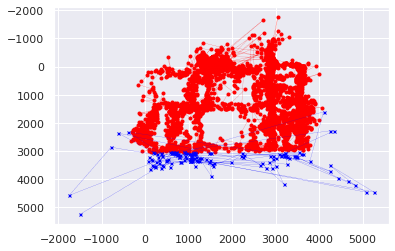

In [3]:
df = find_outliers(df)
outlierit = len(df)

### Edit timestamps in right form, add hour and weekday columns, and remove useless columns
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Datan%20Siivous/clean_dataframe.md


In [4]:
df = clean_dataframe(df)
aukiolot = len(df)

### Discretize x- and y-coordinates, and get grid_id based on discretized coordinates.
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Grid/XY_Diskretisointi.md

In [5]:
grid_size = 30
df = xy_to_grid(df, df.x, df.y, grid_size)
df

node_id               timestamp     x    y  dayofweek  current_hour  \
0           1 2020-06-24 15:20:08.533  2762 -257          2             8   
1           1 2020-06-24 15:20:08.620  2870 -344          2             8   
2           1 2020-06-24 15:20:09.623  2916 -344          2             8   
3           1 2020-06-24 15:20:09.623  2894 -254          2             8   
4           1 2020-06-24 15:20:10.116  2888 -188          2             8   
...       ...                     ...   ...  ...        ...           ...   
9623        1 2020-06-29 13:19:16.418  1301 -120          0             6   
9624        1 2020-06-29 13:19:25.418  1301 -119          0             6   
9625        1 2020-06-29 13:19:35.418  1305 -112          0             6   
9626        1 2020-06-29 13:19:45.418  1305 -112          0             6   
9627        1 2020-06-29 13:19:54.418  1307 -112          0             6   

      x_grid  y_grid  grid_id  
0         21       9      291  
1         21       8      261  
2         22       8      262  
3         21       9      291  
4         21       9      291  
...      ...     ...      ...  
9623      11      10      311  
9624      11      10      311  
9625      11      10      311  
9626      11      10      311  
9627      11      10      311  

[9628 rows x 9 columns]

### Get entry- and cashier area coordinates. Get grid_ids based on those coordinates.
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Data-analyysi/Sis%C3%A4%C3%A4n_ja_ulosk%C3%A4ynnit.md

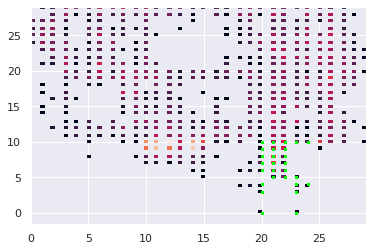

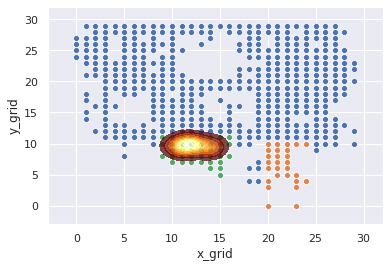

In [6]:
in_x, in_y = sisään(df, 'x_grid', 'y_grid')
out_x, out_y = ulos(df, 'x_grid', 'y_grid')

draw_exits(df, in_x, in_y, out_x, out_y, "x_grid", "y_grid")

# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()


# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df.x_grid, df.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()

### Separate shopping routes from each other
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Reitit/Reittien_erottelu.md

In [7]:
reitit = erottele_reitit(df, u_in_ID, u_out_ID)
reitit = poista_lyhyet_reitit(reitit, grid_size)
df = reitit_dataframeksi(reitit)
erottelu=len(df)

In [8]:
df

ajokerta  node_id               timestamp   x   y  grid_id  \
0           1        1 2020-06-24 15:20:11.820  22  10      322   
1           1        1 2020-06-24 15:20:12.995  22  11      352   
2           1        1 2020-06-24 15:20:13.596  22  11      352   
3           1        1 2020-06-24 15:20:14.482  22  10      322   
4           1        1 2020-06-24 15:20:15.659  23  10      323   
..        ...      ...                     ...  ..  ..      ...   
433        11        1 2020-06-29 12:27:26.418  11  10      311   
434        11        1 2020-06-29 12:27:28.419  11  10      311   
435        11        1 2020-06-29 12:27:29.418  11  10      311   
436        11        1 2020-06-29 12:27:29.418  11  10      311   
437        11        1 2020-06-29 12:27:30.418  11  10      311   

                     kesto  dayofweek  current_hour  
0   0 days 18:00:57.412000          2             8  
1   0 days 18:00:57.412000          2             8  
2   0 days 18:00:57.412000          2             8  
3   0 days 18:00:57.412000          2             8  
4   0 days 18:00:57.412000          2             8  
..                     ...        ...           ...  
433 0 days 16:45:46.771000          0             5  
434 0 days 16:45:46.771000          0             5  
435 0 days 16:45:46.771000          0             5  
436 0 days 16:45:46.771000          0             5  
437 0 days 16:45:46.771000          0             5  

[3298 rows x 9 columns]

### Remove coordinates that has too high velocity, and add distance column
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Datan%20Siivous/Nopeuksien%20Siivous.md

In [9]:
# KOODIT


### Remove datapoints from cashier- and entry area. Remove those shopping trips, which were shopping longer than 2 hours. 

ajokerta  node_id               timestamp   x   y  grid_id    kesto  \
7          2        1 2020-06-25 15:21:46.646  21  11      351  753.002   
8          2        1 2020-06-25 15:21:47.645  21  11      351  753.002   
9          2        1 2020-06-25 15:21:47.645  21  11      351  753.002   
10         2        1 2020-06-25 15:21:47.647  21  11      351  753.002   
11         2        1 2020-06-25 15:21:50.645  19  11      349  753.002   
..       ...      ...                     ...  ..  ..      ...      ...   
60        10        1 2020-06-28 15:44:13.645  13  13      403  105.002   
61        10        1 2020-06-28 15:44:14.645  14  12      374  105.002   
62        10        1 2020-06-28 15:44:14.645  14  13      404  105.002   
63        10        1 2020-06-28 15:44:15.645  14  12      374  105.002   
65        10        1 2020-06-28 15:44:20.646  15  12      375  105.002   

    dayofweek  current_hour  
7           3             8  
8           3             8  
9           3             8  
10          3             8  
11          3             8  
..        ...           ...  
60          6             6  
61          6             6  
62          6             6  
63          6             6  
65          6             6  

[2083 rows x 9 columns]

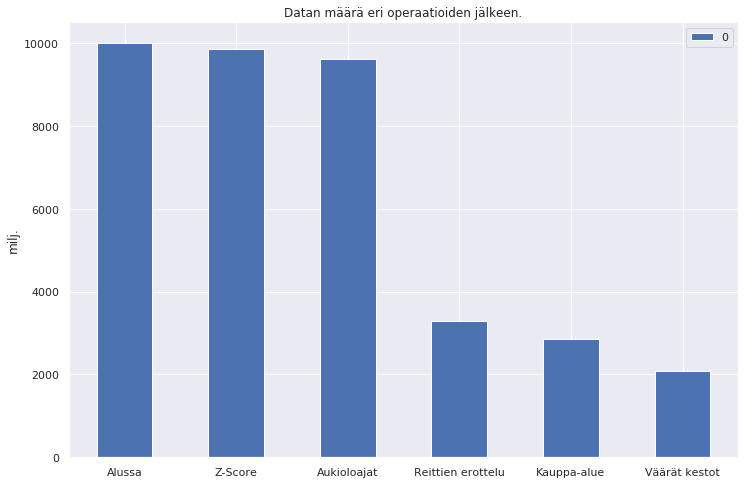

In [10]:
# poistetaan kassa- ja sisääntuloalueella olevat datapisteet
df = df[~df["grid_id"].isin(u_in_ID)]
df = df[~df["grid_id"].isin(u_out_ID)]

alueet = len(df)

# poistetaan reitit, joiden kesto ei ole järkevä
df["kesto"] = df["kesto"].dt.total_seconds()
df = df[df["kesto"] < 7200]
df = df[df["kesto"] > 0]

kestot = len(df)

pd.DataFrame.from_dict([{"Alussa":alussa, "Z-Score":outlierit, "Aukioloajat":aukiolot, "Reittien erottelu":erottelu, "Kauppa-alue":alueet, "Väärät kestot":kestot}]).T.plot.bar(figsize=(12,8), rot=360, ylabel="milj.", title="Datan määrä eri operaatioiden jälkeen.")
df

### Save cleaned shopping trip to database
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/write_df_to_dataframe.md

In [ ]:
write_df_to_mariadb(df, "REITIT")